# TwoLayerNet with Backpropagation

## `Layer` class

In [11]:
import numpy as np
from utility import Utility 

class Layer:
    class Relu:
        def __init__(self):
            self.mask = None

        def forward(self, x):
            self.mask = (x <= 0)
            out = x.copy()
            out[self.mask] = 0

            return out

        def backward(self, dout):
            dout[self.mask] = 0
            dx = dout

            return dx


    class Sigmoid:
        def __init__(self):
            self.out = None
            self.util = Utility()

        def forward(self, x):
            out = self.util.sigmoid(x)
            self.out = out
            return out

        def backward(self, dout):
            dx = dout * (1.0 - self.out) * self.out

            return dx


    class Affine:
        def __init__(self, w, b):
            self.w = w
            self.b = b
            
            self.x = None
            self.original_x_shape = None

            self.dw = None
            self.db = None

        def forward(self, x):
            # 
            self.original_x_shape = x.shape
            x = x.reshape(x.shape[0], -1)
            self.x = x

            out = np.dot(self.x, self.w) + self.b

            return out

        def backward(self, dout):
            dx = np.dot(dout, self.w.T)
            self.dw = np.dot(self.x.T, dout)
            self.db = np.sum(dout, axis=0)
            
            dx = dx.reshape(*self.original_x_shape)  
            return dx


    class SoftmaxWithLoss:
        def __init__(self):
            self.loss = None 
            self.y_hat = None    
            self.y = None    
            self.util = Utility()
            
        def forward(self, x, y):
            self.y = y
            self.y_hat = self.util.softmax(x)
            self.loss = self.util.cross_entropy_error_batch(self.y_hat, self.y)
            
            return self.loss

        def backward(self, dout=1):
            batch_size = self.y.shape[0]
            #if self.y.size == self.y_hat.size: # one hot encoding
            
            dx = (self.y_hat - self.y) / batch_size
            
            """
            else:
                dx = self.y_hat.copy()
                dx[np.arange(batch_size), self.t] -= 1
                dx = dx / batch_size
            """
            return dx

## TwoLayerNet with Backpropagation

In [12]:
from collections import OrderedDict
import numpy as np
from utility import Utility


class TwoLayerNetWithBackprop:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}

        self.params['w1'] = weight_init_std*np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)

        self.params['w2'] = weight_init_std*np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # add layers
        self.layers = OrderedDict()
        self._update_layers()
        self.last_layer = Layer.SoftmaxWithLoss()


    def _update_layers(self):
        self.layers['Affine1'] = Layer.Affine(self.params['w1'], self.params['b1'])
        self.layers['Relu'] = Layer.Relu()
        self.layers['Affine2'] = Layer.Affine(self.params['w2'], self.params['b2'])


    def predict(self, x):
        ## new implementation for backprop
        for layer in self.layers.values():
            x = layer.forward(x)

        y = x
        return y
    
    
    def loss(self, x, y):
        y_hat = self.predict(x)

        # return self.errors.cross_entropy_error(y_hat, y)
        return self.last_layer.forward(y_hat, y)
    
    
    def accuracy(self, x, t):
        y_hat = self.predict(x)
        y_pred = np.argmax(y_hat, axis=1)
        t_true = np.argmax(t, axis=1)

        accuracy = np.sum(y_pred == t_true) / float(x.shape[0])
        return accuracy
    

    def gradient(self, x, y):
        self.loss(x, y)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['w1'] = self.layers['Affine1'].dw
        grads['b1'] = self.layers['Affine1'].db
        grads['w2'] = self.layers['Affine2'].dw
        grads['b2'] = self.layers['Affine2'].db
      
        return grads

## Train `TwoLayerNetWithBackProp` with `MNIST` dataset

### MNIST data

In [13]:
from mnist_data import MnistData

In [14]:
mnist_data = MnistData()
(train_images, train_labels), (test_images, test_labels) = mnist_data.get_dataset()

train-images-idx3-ubyte.gz already exists. Skipping download.
train-labels-idx1-ubyte.gz already exists. Skipping download.
t10k-images-idx3-ubyte.gz already exists. Skipping download.
t10k-labels-idx1-ubyte.gz already exists. Skipping download.
mnist.pkl already exists. Loading dataset from pickle file.


In [15]:
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (60000, 784)
Train labels shape: (60000, 10)
Test images shape: (10000, 784)
Test labels shape: (10000, 10)


### Prepare a neural network using `TwoLayerNetWithBackProp`

In [16]:
net = TwoLayerNetWithBackprop(input_size=28*28, hidden_size=100, output_size=10)

In [17]:
# You may need to adjust the following parameters for your training.
# Training hyperparameters
iterations = 10000
train_size = train_images.shape[0]

batch_size = 100
lr = 0.01

iter_per_ecoph = max(train_size/batch_size, 1)

Start training!

In [18]:
train_losses = []
train_accs = []
test_accs = []

In [19]:
import numpy as np

# Start training!
for i in range(iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = train_images[batch_mask]
    y_batch = train_labels[batch_mask]

    grads = net.gradient(x_batch, y_batch)

    for key in ('w1', 'b1', 'w2', 'b2'):
        net.params[key] -= lr*grads[key]

    ## this is for plotting losses over time
    train_losses.append(net.loss(x_batch, y_batch))

    if i%iter_per_ecoph == 0:
        train_acc = net.accuracy(train_images, train_labels)
        train_accs.append(train_acc)
        test_acc = net.accuracy(test_images, test_labels)
        test_accs.append(test_acc)
        print(f'train acc, test_acc : {train_acc}, {test_acc}')

train acc, test_acc : 0.0932, 0.0974
train acc, test_acc : 0.6828333333333333, 0.6867
train acc, test_acc : 0.8143166666666667, 0.8181
train acc, test_acc : 0.85645, 0.8608
train acc, test_acc : 0.8766, 0.8809
train acc, test_acc : 0.8872833333333333, 0.8906
train acc, test_acc : 0.89465, 0.8967
train acc, test_acc : 0.899, 0.903
train acc, test_acc : 0.9022833333333333, 0.9061
train acc, test_acc : 0.90615, 0.9084
train acc, test_acc : 0.90885, 0.9116
train acc, test_acc : 0.9111166666666667, 0.9153
train acc, test_acc : 0.9139333333333334, 0.9171
train acc, test_acc : 0.9150333333333334, 0.9181
train acc, test_acc : 0.91745, 0.9212
train acc, test_acc : 0.91855, 0.9211
train acc, test_acc : 0.92125, 0.9247


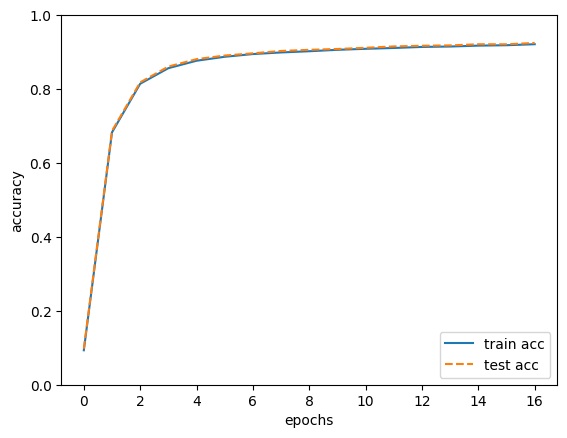

In [20]:
# Plot training loss over iterations
import matplotlib.pyplot as plt

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_accs))
plt.plot(x, train_accs, label='train acc')
plt.plot(x, test_accs, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()